In [1]:
import os
import pandas as pd
import numpy as np
import json
import torch
import sys
from scipy.spatial.distance import pdist, squareform

# Custom modules
project_root = os.path.abspath('/home/jaume/Desktop/Code/stmgcn')
sys.path.append(project_root)

from model.train_stmgcn_ode import build_model_multiplex
from synthetic_data.train_synthetic_models import ObjectiveSynthetic, batch_loop
from synthetic_data.gene_evolution import generate_graph
from utils.model_selection_sklearn import stratified_split
from utils.utils import seed_everything, str2bool, get_best_params
from experiments.ACDC_CV import plot_results, plot_combined_trajectories, get_data_in_original_scale
from experiments.ACDC_All import plot_predicted_trajectories
import torchvision.transforms as transforms
from utils.model_selection_optuna import hypertune_optuna
from model.testing_model import get_latex_table, wrap_latex_table, save_training_convergence
from synthetic_data.lorenz_model import LorenzDataset


/home/jaume/miniconda3/envs/pyMultiplex/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_folder = "/media/jaume/DATA/Data/Multiplex_Synthetic_FINAL"
study_name = "Multiplex_Lorenz_DIMENSIONS_NEW_LOSS"

In [3]:
# Sahred parameters
use_global_data = False
use_position = False
use_region_id = False

use_time = False
use_edges = True
use_norm = True
normalization = "ZNorm"
norm_by_group = False # Normalize by group, i.e: healthy controls
norm_only_ed = False  # Normalize only by the ED frame
device = "cpu"
use_similarity = False
reprocess_datasets = False

space_coupling = 1
time_coupling = 1
reprocess = False

In [4]:
seed_everything()
duration = 2.5
dt = 0.05
k = 0.01
num_nodes = 3
num_samples = 500
dataset_name = f'duration-{duration}_dt-{dt}_k-{k}_nodes-{num_nodes}'

# Save folder
save_folder = os.path.join(data_folder, "LorenzAttractor_Graphs", f"{dataset_name}")

In [5]:
# Load previous data
model_filename = os.path.join(save_folder, 'FinalModel', 'model.pt')
params_filename = os.path.join(save_folder, f'objective_params_{study_name}.json')

# Create the dataset
dataset = LorenzDataset(name='LorenzAttractor',
                        save_dir=save_folder, 
                        reprocess=reprocess, 
                        k=k, 
                        num_nodes=num_nodes,
                        space_coupling=space_coupling, 
                        time_coupling=time_coupling, 
                        dt=dt, 
                        duration=duration, 
                        num_samples=num_samples,
                          )

# Read the params filename from the JSON
with open(params_filename, 'r') as f:
    params_dict = json.load(f)

# Load the study parameters
results_hp_folder = os.path.join(data_folder, "LorenzAttractor_Graphs", "results")
df_params_path = os.path.join(results_hp_folder, f'{study_name}_trials.csv')
df_params = pd.read_csv(df_params_path)
df_params.dropna(how='any', inplace=True)
df_params = df_params.sort_values(by='value', ascending=False)
# params_names = [key for key in df_params.columns if key.startswith('params_')]
# best_params = df_params.iloc[0].to_dict()
# best_params = df_params.iloc[0:5][params_names].mean().to_dict()
# best_params = {key.replace('params_', ''): value for key, value in best_params.items() if key.startswith('params_')}
best_params = get_best_params(df_params.iloc[0:5], use_median=True)
# best_params['hidden_dim'] = 17

# Update the param_dict
params_dict.update(best_params)

In [6]:
# Create the objective
objective_optuna = ObjectiveSynthetic(study_name,
                                        dataset,
                                        normalization=normalization,
                                        norm_only_ed=False,
                                        save_dir=save_folder,
                                        direction="maximize",
                                        device = device,
                                        track_experiment=False,
                                        use_position=use_position,
                                        use_region_id=use_region_id,
                                        use_time=use_time,
                                        fn_batch_loop=batch_loop,
                                        class_dim=0,
                                        space_planes=params_dict.get('space_planes', 3),
                                        time_planes=params_dict.get('time_planes', 3),
                                        depth_nodes=1,
                                        depth_edges=1,
                                        use_edges=use_edges,
                                        only_spatial=False,
                                        use_norm=use_norm,
                                        use_mse=False,
                                        )
objective_optuna.set_default_params(params_dict)

# Indices for the train / valid split
# train_idx = graph_train_dataset.idx_train
# valid_idx = graph_train_dataset.idx_valid
# test_idx = graph_train_dataset.idx_test
# objective_optuna.set_indices(train_idx, valid_idx, test_idx=test_idx)

indices = np.arange(len(dataset))
labels = np.ones(len(dataset))  # Dummy labels
splits = stratified_split(indices, labels, test_size=0.2, valid_size=0.2)
train_idx = splits['X_train']
valid_idx = splits['X_valid']
test_idx = splits['X_test']
objective_optuna.set_indices(train_idx, valid_idx, test_idx=test_idx)

In [7]:
print(params_dict)
print(objective_optuna.out_dim)
print(best_params)

{'init_lr': 0.01, 'hidden_dim_ext': 0, 'use_edges': True, 'use_global_data': False, 'dropout': 0.0, 'l1_weight': 0.0, 'l2_weight': 0.0, 'weight_decay': np.float64(0.0003583372642973), 'node_aggr': 'mean', 'graph_pooling': 'mlp', 'imbalance_weight': 1, 'batch_size': 30, 'num_epochs': 300, 'loss_balance': 1, 'use_attention': False, 'use_constant_edges': False, 'gamma_rec': np.float64(0.8837002403106651), 'gamma_lat': np.float64(0.1393916193959628), 'gamma_bc': 0.0, 'gamma_class': 0.0, 'gamma_graph': np.float64(0.1023920400221566), 'decode_just_latent': False, 'space_planes': 2, 'time_planes': 5, 'depth_nodes': 1, 'depth_edges': 2, 'use_position': False, 'use_region': False, 'use_time': False, 'use_hdyn': True, 'cond_on_time': False, 'gamma_focal': 1, 'weight_classes': None, 'dt_step': 0.04, 'only_spatial': False, 'use_norm': True, 'use_mse': False, 'classify': False, 'predict_external': False, 'use_diffusion': False, 'use_einsum': False, 'agg_type': 'score', 'compute_derivative': True, '

In [8]:
# Model
model = objective_optuna.build_model(params_dict)
tmp_save = os.path.join(save_folder, 'FinalModel')
res_training = objective_optuna._train(model, params_dict, tmp_save, final_model=True)  # Reload

2025-07-15 14:40:42,620 - INFO - Logging to file and console...
2025-07-15 14:40:42,621 - INFO - Saving data to /media/jaume/DATA/Data/Multiplex_Synthetic_FINAL/LorenzAttractor_Graphs/duration-2.5_dt-0.05_k-0.01_nodes-3/FinalModel

2025-07-15 14:40:42,622 - INFO - Loading trained model...

/home/jaume/Desktop/Code/stmgcn/baselines/train_utils.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Loading trained model...

Trained model loaded successfully.
Model trained!
==== Best epoch: 138 [138/300] ====
Training:
Loss: -2.9697	Accuracy: 0.0000
Validation:
Loss: -2.0644	Accuracy: 0.0000
Test:
Loss: -2.0692	Accuracy: 0.0000
Best Score: -0.7163



In [30]:
steps_to_predict = int(duration/dt)
# steps_to_predict = int(duration / dt_step_size)
# print(steps_to_predict)
# time_to_predict = np.arange(0, steps_to_predict, 1)  # Predict 100 steps more
time_to_predict = torch.arange(0, steps_to_predict, 1)
pred_trajectory, pred_latent, tgt_trajectory = objective_optuna.predict_from_latent(model, objective_optuna.dataset, time_to_predict, params_dict, device=device)
# The shape of the results is [num_samples, num_features, num_nodes, num_time_steps]

# Convert to the true scale
trans_fts_predict = objective_optuna.dataset._transform['nfeatures']
fts_to_predict = np.arange(0, 3)
num_subjects, _, _, time_frames = tgt_trajectory.shape
time_frames_true = tgt_trajectory.shape[-1]
trans_fts_mean = trans_fts_predict.mean[..., fts_to_predict].unsqueeze(0).unsqueeze(-1).repeat(num_subjects, 1, 1, time_frames_true).permute(0, 2, 1, 3)
trans_fts_std = trans_fts_predict.std[..., fts_to_predict].unsqueeze(0).unsqueeze(-1).repeat(num_subjects, 1, 1, time_frames_true).permute(0, 2, 1, 3)
true_trajectory = (tgt_trajectory * trans_fts_std) + trans_fts_mean


In [31]:


# Save as metric the error in the predicted trajectory
total_mse = (tgt_trajectory - pred_trajectory.mean[..., 1:]).square().mean(dim=0).sum()
df_mse = pd.DataFrame({'MSE': [total_mse.item()]})
df_mse.to_csv(os.path.join(save_folder, 'mse.csv'))

# Per feature
df_errors = get_data_in_original_scale(model, objective_optuna, params_dict, save_folder, pred_trajectory, 
                                        fts_to_predict=None, true_trajectory=tgt_trajectory, normalization=normalization)
df_errors.to_csv(os.path.join(save_folder, 'errors_per_feature.csv'))

latex_table = get_latex_table(df_errors, objective_optuna)
latex_table = latex_table.replace('train', 'train window')
latex_table= latex_table.replace('predict', 'extrapolation')
wrapped_table = wrap_latex_table(latex_table, caption="Errors per feature in the test set", label="tab:feature_errors_pendulum")
print(wrapped_table)

Epoch 0 batches: 100%|██████████| 1/1 [00:00<00:00,  2.17batch/s]

\begin{table}[!htb]
    \centering
    \setlength\tabcolsep{3pt} % default value: 6pt
    \caption{Errors per feature in the test set}
    \label{tab:feature_errors_pendulum}
    \resizebox{\columnwidth}{!}{%
    $\begin{tabular}{llcccc}
\toprule
Set & Feature & MSE $\pm$ IQR & MAE $\pm$ IQR & MSE [$\%$] & MAE [$\%$] \\
\midrule
train window & $x$ & 0.0850 $\pm$ 0.4439 & 0.2915 $\pm$ 0.5399 & 0.12$\%$ & 3.51$\%$ \\
train window & $y$ & 0.1637 $\pm$ 0.6496 & 0.4045 $\pm$ 0.6079 & 0.21$\%$ & 4.61$\%$ \\
train window & $z$ & 0.1431 $\pm$ 0.5703 & 0.3782 $\pm$ 0.5767 & 0.02$\%$ & 1.54$\%$ \\
extrapolation & $x$ & 0.0700 $\pm$ 0.1821 & 0.2645 $\pm$ 0.3206 & 0.10$\%$ & 3.11$\%$ \\
extrapolation & $y$ & 0.1069 $\pm$ 0.3290 & 0.3269 $\pm$ 0.4332 & 0.15$\%$ & 3.89$\%$ \\
extrapolation & $z$ & 0.1277 $\pm$ 0.3957 & 0.3573 $\pm$ 0.4800 & 0.02$\%$ & 1.33$\%$ \\
\bottomrule
\end{tabular}
$
    } % end resizebox
    \end{table}


In [33]:
# =================== LOCF Baseline =====================
# Load data
data_filename = os.path.join(save_folder, 'data.pkl')
data = torch.load(data_filename, map_location=device)
tgt_trajectories = data['tgt_trajectories'].numpy()
locf_value = tgt_trajectories[:, :, :, [-1]]  # Last value in the trajectory

# # Error w.r.t the future trajectories
# abs_error = np.abs(true_trajectory - locf_value)
# squared_error = abs_error ** 2

# Initialize storage
metrics = {
    'Dimension': [],
    'MAE': [],
    'MSE': [],
    'MAPE (%)': [],
    'MSPE (%)': [],
    'IQR (Abs Error)': []
}

N, D, R, T = tgt_trajectory.shape
dimension_names = ['$x$', '$y$', '$z$']
for d in range(D):  # For each dimension
    rec_d = locf_value[:, d, :, :] #.flatten()
    tgt_d = true_trajectory[:, d, :, :].numpy() #.flatten()

    print(rec_d.shape, tgt_d.shape)

    abs_err = np.abs(rec_d - tgt_d)
    sq_err = (rec_d - tgt_d) ** 2

    # Handle small values in denominator to avoid division by zero
    tgt_d_safe = np.clip(np.abs(tgt_d), 1e-8, None)

    mae = np.mean(abs_err)
    mse = np.mean(sq_err)
    mape = np.mean(abs_err / tgt_d_safe) * 100
    mspe = np.mean(sq_err / tgt_d_safe) * 100
    iqr = np.percentile(abs_err, 75) - np.percentile(abs_err, 25)

    # Store metrics
    metrics['Dimension'].append(dimension_names[d])
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['MAPE (%)'].append(mape)
    metrics['MSPE (%)'].append(mspe)
    metrics['IQR (Abs Error)'].append(iqr)

# print(abs_error.shape)
# print(data.keys())

# Create and display DataFrame
df_metrics = pd.DataFrame(metrics)
print(df_metrics)

for i, row in df_metrics.iterrows():
    print(f"extrapolation & {row['Dimension']} & "
          f"{row['MSE']:.4f} $\\pm$ {row['IQR (Abs Error)']:.4f} & "
          f"{row['MAE']:.4f} $\\pm$ {row['IQR (Abs Error)']:.4f} & "
          f"{row['MSPE (%)']:.2f}\\% & {row['MAPE (%)']:.2f}\\% \\\\")


(500, 3, 1) (500, 3, 50)
(500, 3, 1) (500, 3, 50)
(500, 3, 1) (500, 3, 50)
  Dimension       MAE       MSE   MAPE (%)   MSPE (%)  IQR (Abs Error)
0       $x$  0.994640  1.582157  11.372670  17.568537         1.259502
1       $y$  1.449570  3.421382  15.974763  35.854416         1.974653
2       $z$  1.664081  4.059275   6.222878  15.186289         1.700307
extrapolation & $x$ & 1.5822 $\pm$ 1.2595 & 0.9946 $\pm$ 1.2595 & 17.57\% & 11.37\% \\
extrapolation & $y$ & 3.4214 $\pm$ 1.9747 & 1.4496 $\pm$ 1.9747 & 35.85\% & 15.97\% \\
extrapolation & $z$ & 4.0593 $\pm$ 1.7003 & 1.6641 $\pm$ 1.7003 & 15.19\% & 6.22\% \\


/tmp/ipykernel_168955/2118320183.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_filename, map_location=device)


In [29]:
print(tgt_trajectories.mean(axis=0).mean(axis=-1))

print(tgt_trajectories[..., -1].mean(axis=0))
print(tgt_trajectory[..., 0].mean(axis=0))

[[-3.7855491e-02  1.5186877e-02 -2.4426728e-01]
 [-4.2534780e-02  1.7903691e-02 -2.5746250e-01]
 [ 2.3941578e+01  2.3965061e+01  2.3907846e+01]]
[[-0.05206929  0.10894249 -0.35340822]
 [-0.06881616  0.0843127  -0.30629224]
 [26.972326   26.931002   27.013254  ]]
tensor([[ 0.0080,  0.0258, -0.0248],
        [ 0.0060,  0.0193, -0.0211],
        [ 0.2127,  0.2128,  0.2196]])


In [26]:
save_format = 'eps'  # svg, png, pdf, eps
import matplotlib as mpl
mpl.rcParams.update({
    'axes.titlesize': 28,
    'axes.labelsize': 28,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'legend.fontsize': 10
})

plot_combined_trajectories(model, objective_optuna, params_dict, save_folder, pred_latent, pred_trajectory, plot_individual=True, plot_spatial=False, 
                            fts_to_predict=None, true_trajectory=tgt_trajectory, normalization=normalization, save_format=save_format)
plot_predicted_trajectories(objective_optuna, pred_latent, pred_trajectory, save_folder, 
                            normalization=normalization, plot_individual=True, true_trajectory=tgt_trajectory, 
                            plot_spatial=False, save_format=save_format)
save_training_convergence(res_training, save_folder, save_format=save_format)
plot_results(model, objective_optuna, params_dict, save_folder, plot_individual=True, plot_spatial=False, save_format=save_format)

Epoch 0 batches: 100%|██████████| 1/1 [00:00<00:00,  1.45batch/s]
2025-07-15 12:46:27,724 - INFO - Plotting the convergence results...
2025-07-15 12:46:27,824 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-07-15 12:46:27,849 - INFO - Convergence results plotted!
2025-07-15 12:46:27,850 - INFO - ALL DONE. Results available at: /media/jaume/DATA/Data/Multiplex_Synthetic_FINAL/CoupledPendulum_Graphs/duration-10.0_dt-0.1_k-2.0
Epoch 0 batches: 100%|██████████| 1/1 [00:00<00:00,  1.29batch/s]
2025-07-15 12:46:29,406 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-15 12:46:29,416 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 2.236708


2025-07-15 12:46:30,332 - INFO - Latent space computed!
2025-07-15 12:46:30,335 - INFO - Plotting the latent space...


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.955315
[t-SNE] KL divergence after 300 iterations: 0.832690


/home/jaume/Desktop/Code/stmgcn/utils/plot_utils.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
2025-07-15 12:46:30,724 - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2025-07-15 12:46:30,779 - INFO - Latent space plotted!
2025-07-15 12:46:30,780 - INFO - Computing the latent space...
/home/jaume/miniconda3/envs/pyMultiplex/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
2025-07-15 12:46:30,867 - INFO - Latent space computed!
2025-07-15 12:46:30,868 - INFO - Plotting the latent space...
/home/jaume/Desktop/Code/stmgcn/utils/plot_utils.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an under

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 3.906745
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.514526
[t-SNE] KL divergence after 300 iterations: 0.343678


Epoch 0 batches: 100%|██████████| 1/1 [00:00<00:00,  1.48batch/s]


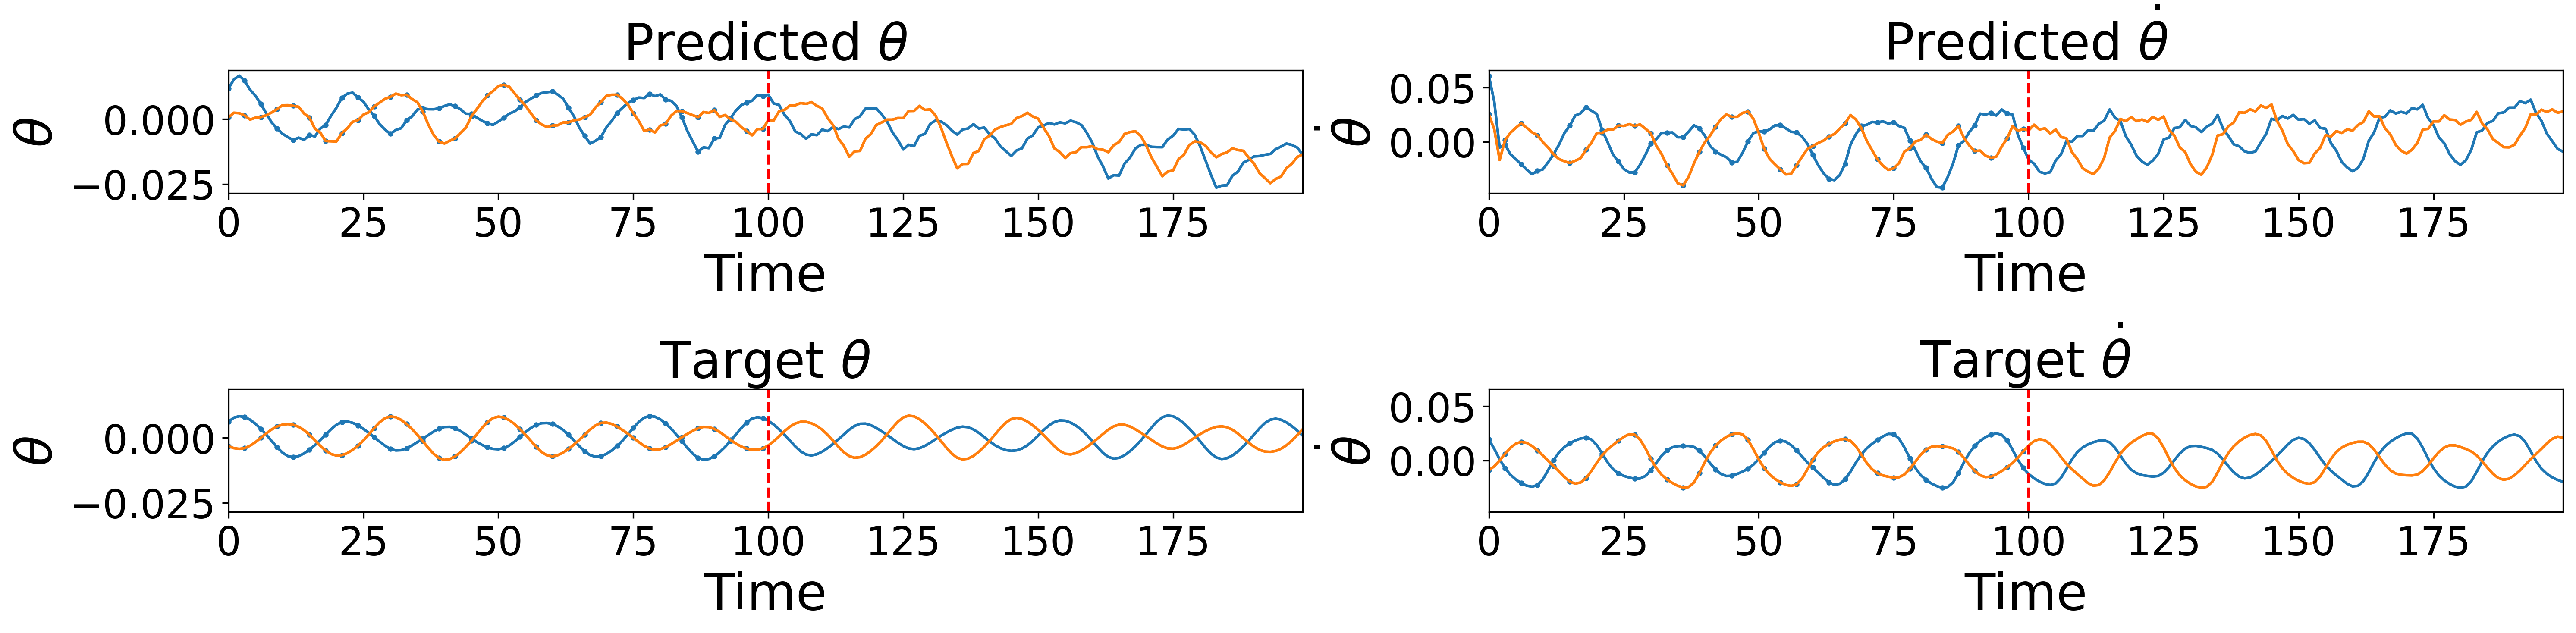

In [28]:
plot_combined_trajectories(model, objective_optuna, params_dict, save_folder, pred_latent, pred_trajectory, plot_individual=True, plot_spatial=False, 
                            fts_to_predict=None, true_trajectory=tgt_trajectory, normalization=normalization, save_format='png')

# Check plots here 
from IPython.display import Image, display

mean_img_filename = os.path.join(save_folder, 'mean_combined.png')
display(Image(filename=mean_img_filename))

# mean_img_filename = os.path.join(all_data_folder, 'mean_combined.eps')
# display(Image(filename=mean_img_filename))